
Name: Saad Naeem (405960), Ahmad Zeeshan (403866), Talha Razzaq (418013)

Syndicate A – DE-44-CE

In [ ]:
!pip install tensorflow==2.17.1
!pip install tensorflow-io==0.37.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 11.0 MB/s eta 0:00:00


In [ ]:
import os
import pickle
import wave
import csv
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical
from itertools import groupby

Paths of dataset and audio.csv

In [ ]:
data_dir = os.path.join('/content','drive','My Drive','SNS_project_dataset','UrbanSound8K.tar','UrbanSound8K','UrbanSound8K','metadata')
audio_dir = os.path.join('/content','drive','My Drive','SNS_project_dataset','UrbanSound8K.tar','UrbanSound8K','UrbanSound8K','audio')

In [ ]:
data_csv = pd.read_csv(os.path.join(data_dir, 'UrbanSound8K.csv'))

Extracting all labels/classes

In [ ]:
class_names = data_csv['class'].unique()

Storing each .wav with there indiviual label via hashmap

In [ ]:
Data = {}

for slice_file_name, class_name in zip(data_csv['slice_file_name'], data_csv['class']):
    Data[slice_file_name] = class_name


Function to check if .wav file is corrupted or not

In [ ]:
def validate_wav(filepath):
    try:
        with wave.open(filepath, 'rb') as wav_file:
            wav_file.readframes(1)
            print(f"file added: {filepath}")
        return True
    except Exception as e:
        return False

In [ ]:
folder1 = os.path.join(audio_dir, 'fold7', '104625-4-0-15.wav')
try:
        with wave.open(folder1, 'rb') as file:
            print(f"Channels: {file.getnchannels()}")
            print(f"Sample rate: {file.getframerate()}")
            print(f"Number of frames: {file.getnframes()}")
except Exception as e:
        print(f"Error opening file {folder1}: {e}")

Error opening file /content/drive/My Drive/SNS_project_dataset/UrbanSound8K.tar/UrbanSound8K/UrbanSound8K/audio/fold7/104625-4-0-15.wav: unknown format: 65534


Storing whole path of .wav file with there repective label bypassing the corrupted files in a hashmap

In [ ]:
data = {}

for folders in os.listdir(audio_dir):
  audio_folder = os.path.join(audio_dir,folders)
  for files in os.listdir(audio_folder):
    if files.endswith('.wav'):
      full_audio_path = os.path.join(audio_folder,files)
      if validate_wav(full_audio_path) and files not in data:
        data[full_audio_path] = Data[files]

In [ ]:
print (data)

{'/content/drive/My Drive/SNS_project_dataset/UrbanSound8K.tar/UrbanSound8K/UrbanSound8K/audio/fold7/101848-9-0-3.wav': 'street_music', '/content/drive/My Drive/SNS_project_dataset/UrbanSound8K.tar/UrbanSound8K/UrbanSound8K/audio/fold7/101848-9-0-0.wav': 'street_music', '/content/drive/My Drive/SNS_project_dataset/UrbanSound8K.tar/UrbanSound8K/UrbanSound8K/audio/fold7/101848-9-0-2.wav': 'street_music', '/content/drive/My Drive/SNS_project_dataset/UrbanSound8K.tar/UrbanSound8K/UrbanSound8K/audio/fold7/101848-9-0-1.wav': 'street_music', '/content/drive/My Drive/SNS_project_dataset/UrbanSound8K.tar/UrbanSound8K/UrbanSound8K/audio/fold7/102853-8-0-5.wav': 'siren', '/content/drive/My Drive/SNS_project_dataset/UrbanSound8K.tar/UrbanSound8K/UrbanSound8K/audio/fold7/102853-8-0-0.wav': 'siren', '/content/drive/My Drive/SNS_project_dataset/UrbanSound8K.tar/UrbanSound8K/UrbanSound8K/audio/fold7/101848-9-0-9.wav': 'street_music', '/content/drive/My Drive/SNS_project_dataset/UrbanSound8K.tar/UrbanS

hot-encoding each label (assigning it an number) and creating dataset to train model

In [ ]:
wav_files = tf.data.Dataset.from_tensor_slices(list(data.keys()))

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(list(data.values()))
labels = to_categorical(labels, num_classes=10)
labels = tf.data.Dataset.from_tensor_slices(labels)

Dataset = tf.data.Dataset.zip(wav_files, labels)
print("Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Mapping: {'air_conditioner': 0, 'car_horn': 1, 'children_playing': 2, 'dog_bark': 3, 'drilling': 4, 'engine_idling': 5, 'gun_shot': 6, 'jackhammer': 7, 'siren': 8, 'street_music': 9}


In [ ]:
file_name = list(data.keys())[0]
wave_file, label = Dataset.as_numpy_iterator().next()
print(file_name)
load_wav_16k_mono(file_name)
load_wav_16k_mono(wave_file)

decoding wav_file at the given filepath and sampling it at an rate of 16kHz with channel mono (returning wav information numerical representation)

In [ ]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

making the spectrogram of the respective wav, each wav file is sampled upto 3s only

In [ ]:
def preprocessed(filepath, label):
    try:
        wav = load_wav_16k_mono(filepath)
        wav = wav[:48000]
        zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
        wav = tf.concat([wav, zero_padding], 0)
        spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
        spectrogram = tf.abs(spectrogram)
        spectrogram = tf.expand_dims(spectrogram, axis=2)
        spectrogram = tf.ensure_shape(spectrogram, [1491, 257, 1])
        return spectrogram, label
    except tf.errors.InvalidArgumentError as e:
        print(f"Error processing file {filepath}: {e}")
        return None, None


In [ ]:
wave_file, label = Dataset.shuffle(10000).as_numpy_iterator().next()
spectrogram , label = preprocessed(wave_file, label)

[]

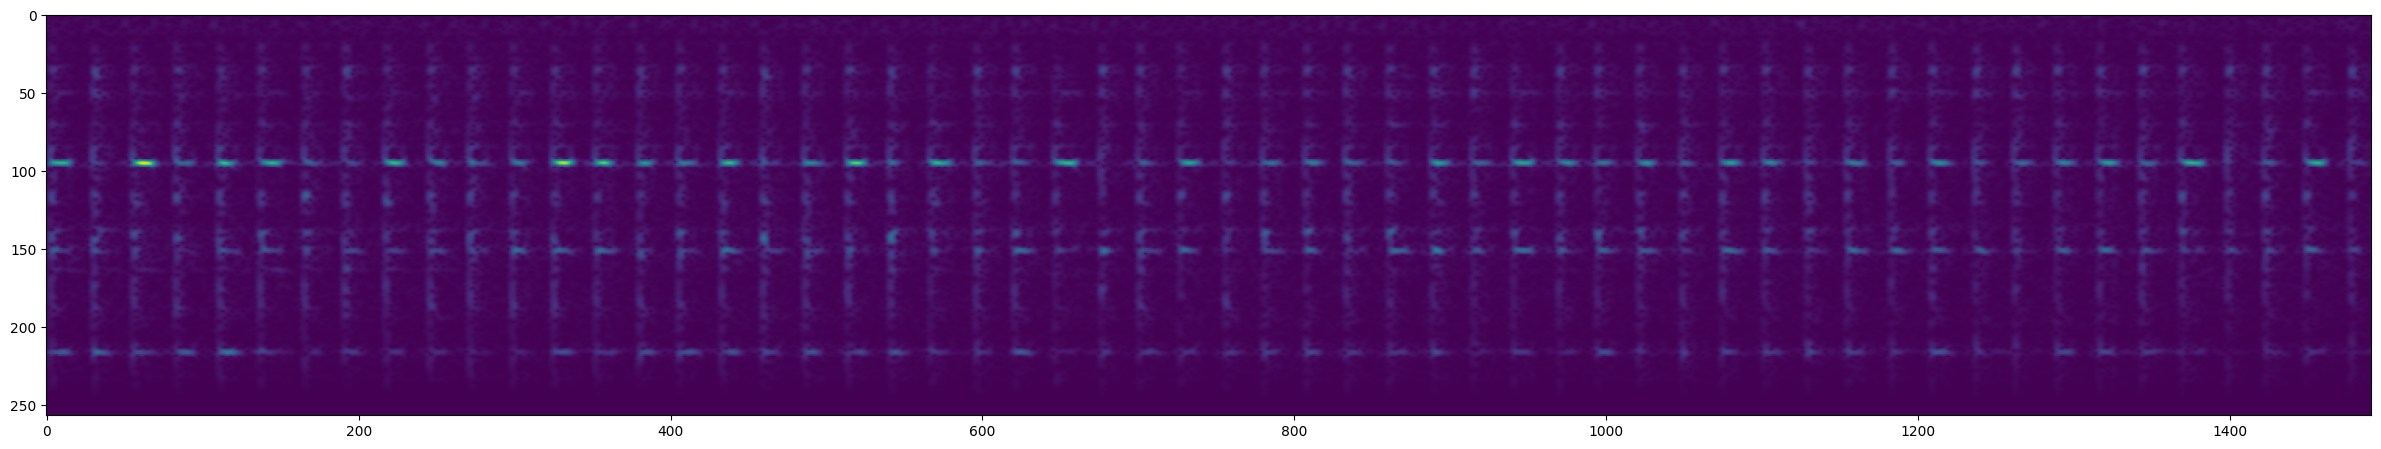

In [ ]:
plt.figure(figsize= (30, 20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.plot()

In [ ]:
for wave_file, label in Dataset:
  try:
    load_wav_16k_mono(wave_file)
  except tf.errors.InvalidArgumentError as e:
    print(f"Error processing file {wave_file}: {e}")

Coverting all the Dataset into an spectrogram and label tuple and batching caching and prefetching it

In [ ]:
Dataset = Dataset.map(lambda filepath, label: (tf.image.resize(preprocessed(filepath, label)[0], [256, 128]), label))

Dataset = Dataset.cache()
Dataset = Dataset.shuffle(1000)
Dataset = Dataset.batch(16, drop_remainder=True)

Dataset = Dataset.prefetch(8)

# [256, 128, 1, 16]


Creating training and testing data where training data is 70% and testing is 30% of the original Dataset

In [ ]:
print((len(Dataset)/16))

train = Dataset.take(252) # ((len(Dataset)/16))*0.7
test  = Dataset.skip(252).take(107) #((len(Dataset)/16))*0.3

22.4375


Model pipeline

In [ ]:
model = Sequential()
model.add(Conv2D(16, [3,3], activation = 'relu', input_shape=[256, 128, 1]))
model.add(Conv2D(16, [3,3], activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 126, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 252, 124, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 499968)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      63,996,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 191,999,408 (732.42 MB)

 Trainable params: 63,999,802 (244.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 127,999,606 (488.28 MB)

In [ ]:
model.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
model.fit(train, epochs=1, validation_data=test)

252/252 ━━━━━━━━━━━━━━━━━━━━ 1399s 6s/step - loss: 0.0707 - precision: 0.9934 - recall: 0.9717 - val_loss: 1.4004 - val_precision: 0.8003 - val_recall: 0.7044


Saving and loading model training history in a file

In [ ]:
model_dir = os.path.join('/content','drive','My Drive','SNS_project_dataset','multi_label_classification.pkl')

In [ ]:
with open(model_dir, 'wb') as f:
  pickle.dump(model, f)

In [ ]:
with open(model_dir, 'rb') as f:
  model = pickle.load(f)

Testing model accuracy for an sample testing data

In [ ]:
testx, testy = test.shuffle(1000).as_numpy_iterator().next()

In [ ]:
pred = model.predict(testx)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


In [ ]:
print(pred)
print(testy)

In [ ]:
def non_tabular_form(pred):
  non_tabular = {}
  flag = False
  for row_index, row in enumerate(pred):
    for col_index, col in enumerate(row):
      if col == 1:
        non_tabular[row_index] = col_index
        flag = True
        break
      if flag is not True:
        non_tabular[row_index] = -1

  return non_tabular

Converting model prediction into 1's and 0's with a confidence interval of [30, 70]

In [ ]:
from math import inf

def binary_conversion(pred):
  new_pred = []
  for row in pred:
    n_row = []
    row_number = 0
    largest = -inf

    for i,prediction in enumerate(row):
      if largest < prediction:
        largest = prediction
        row_number = i

      n_row.append(0)

    n_row[row_number] = 1
    new_pred.append(n_row)

  new_pred = np.array(new_pred)
  return new_pred

In [ ]:
new_pred = binary_conversion(pred)
print(new_pred)
print(testy)

[[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]]
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]], shape=(16, 10), dtype=float64)


In [ ]:
print(non_tabular_form(new_pred))
print(non_tabular_form(testy))
non_tab_pred = non_tabular_form(new_pred)
non_tab_testy = non_tabular_form(testy)

arr1 = np.array(list(non_tab_pred.values()))
arr2 = np.array(list(non_tab_testy.values()))
print((sum(arr1 == arr2)))
print(arr2)
print(arr1)


{0: 7, 1: 9, 2: 9, 3: 8, 4: 8, 5: 9, 6: 0, 7: 0, 8: 8, 9: 4, 10: 5, 11: 4, 12: 2, 13: 5, 14: 2, 15: 1}
{0: 7, 1: 9, 2: 9, 3: 2, 4: 2, 5: 9, 6: 0, 7: 0, 8: 8, 9: 4, 10: 5, 11: 4, 12: 2, 13: 5, 14: 2, 15: 1}
14
[7 9 9 2 2 9 0 0 8 4 5 4 2 5 2 1]
[7 9 9 8 8 9 0 0 8 4 5 4 2 5 2 1]


In [ ]:
mapping = {
    0: 'noise' , # 0,1,3,4,5,6,7,8
    1: 'noise',  # 2
    2: 'speech', #children playing # 3
    3: 'noise',
    4: 'noise',
    5: 'noise',
    6: 'noise',
    7: 'noise',
    8: 'noise',
    9: 'music',  #street music
}

Testing accuracy function

In [ ]:
accuarcy = 0.0
testing_accuarcy_req = 0.0

overall_results = []
number = 0
for testx, testy in test:
  pred_y = model.predict(testx)
  binary_pred_y = binary_conversion(pred_y)

  non_tab_pred_y = non_tabular_form(binary_pred_y)
  non_tab_testy  = non_tabular_form(testy)

  arr1 = np.array(list(non_tab_pred_y.values()))
  arr2 = np.array(list(non_tab_testy.values()))

  number1 = number
  for i, k in zip(arr1, arr2):
    overall_results.append([f'TestFile {number1}', mapping[k], mapping[i]], )
    number1 += 1
    if mapping[i] == mapping[k]:
      testing_accuarcy_req += 1

  accuarcy += sum(arr1 == arr2)
  number += 16

  print(sum(arr1 == arr2))
  print(non_tabular_form(binary_pred_y))
  print(non_tabular_form(testy))


length = len(test)*testy.shape[0]

accuarcy = accuarcy/length
testing_accuarcy_req = testing_accuarcy_req/length
print(f'testing accuarcy = {accuarcy}')
print(f'testing accuracy 3 labels = {testing_accuarcy_req}')

In [ ]:
accuarcy = 0.0
testing_accuarcy_req = 0.0

overall_results1 = []
number = 0
for testx, testy in train:
  pred_y = model.predict(testx)
  binary_pred_y = binary_conversion(pred_y)

  non_tab_pred_y = non_tabular_form(binary_pred_y)
  non_tab_testy  = non_tabular_form(testy)

  arr1 = np.array(list(non_tab_pred_y.values()))
  arr2 = np.array(list(non_tab_testy.values()))

  number1 = number
  for i, k in zip(arr1, arr2):
    overall_results1.append([f'TestFile {number1}', mapping[k], mapping[i]], )
    number1 += 1
    if mapping[i] == mapping[k]:
      testing_accuarcy_req += 1

  accuarcy += sum(arr1 == arr2)
  number += 16

  print(sum(arr1 == arr2))
  print(non_tabular_form(binary_pred_y))
  print(non_tabular_form(testy))


length = len(train)*testy.shape[0]

accuarcy = accuarcy/length
testing_accuarcy_req = testing_accuarcy_req/length
print(f'testing accuarcy = {accuarcy}')
print(f'testing accuracy 3 labels = {testing_accuarcy_req}')

In [ ]:
print(overall_results)

[['TestFile 0', 'noise', 'noise'], ['TestFile 1', 'noise', 'noise'], ['TestFile 2', 'noise', 'noise'], ['TestFile 3', 'noise', 'noise'], ['TestFile 4', 'noise', 'noise'], ['TestFile 5', 'noise', 'noise'], ['TestFile 6', 'noise', 'noise'], ['TestFile 7', 'music', 'music'], ['TestFile 8', 'speech', 'noise'], ['TestFile 9', 'noise', 'speech'], ['TestFile 10', 'noise', 'noise'], ['TestFile 11', 'speech', 'noise'], ['TestFile 12', 'noise', 'noise'], ['TestFile 13', 'speech', 'noise'], ['TestFile 14', 'noise', 'noise'], ['TestFile 15', 'noise', 'noise'], ['TestFile 16', 'noise', 'noise'], ['TestFile 17', 'noise', 'noise'], ['TestFile 18', 'noise', 'noise'], ['TestFile 19', 'noise', 'music'], ['TestFile 20', 'noise', 'noise'], ['TestFile 21', 'noise', 'noise'], ['TestFile 22', 'speech', 'speech'], ['TestFile 23', 'noise', 'noise'], ['TestFile 24', 'noise', 'noise'], ['TestFile 25', 'noise', 'noise'], ['TestFile 26', 'noise', 'noise'], ['TestFile 27', 'noise', 'noise'], ['TestFile 28', 'noise'

In [ ]:
Data_dir = os.path.join('/content', 'drive', 'MyDrive','SNS_project_dataset','SNS_project_results.csv')
with open(Data_dir, 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['Wave_file', 'Actual label', 'Predicted label'])
    for TestFile, actuallabel, predictedlabel in overall_results:
        writer.writerow([TestFile, actuallabel, predictedlabel])

In [ ]:
# Limit results to the first 200 samples
overall_results_limited = overall_results1

# Count correct and incorrect predictions
correct_predictions = sum(
    1 for result in overall_results_limited if result[1] == result[2]
)
incorrect_predictions = len(overall_results_limited) - correct_predictions

# Data for the pie chart
labels = ["Correct Predictions", "Incorrect Predictions"]
sizes = [correct_predictions, incorrect_predictions]
colors = ["#4CAF50", "#F44336"]  # Green for correct, red for incorrect
explode = (0.1, 0)  # Slightly "explode" the correct predictions slice

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct="%1.1f%%",
    startangle=90,
    shadow=True,
)
plt.title("Training data Prediction Accuracy")
plt.axis("equal")  # Equal aspect ratio ensures the pie is circular
plt.show()
